In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction

#### I've also written a **TowardsDataScience** Blog post explaining my project. All the explanations are avialbe in the markdowns of this notebook too.

It was in January of 2021 that **OpenAI** announced two new models: **DALL-E** and **CLIP**, both **multi-modality** models connecting **texts and images** in some way. In this article we are going to implement CLIP model from scratch in **PyTorch**. OpenAI has open-sourced some of the code relating to CLIP model but I found it intimidating and it was far from something short and simple. I also came across a good tutorial inspired by CLIP model on Keras code examples and I translated some parts of it into PyTorch to build this tutorial totally with our beloved PyTorch!

### What does CLIP do? Why is it fun?

In [Learning Transferable Visual Models From Natural Language Supervision paper](https://arxiv.org/abs/2103.00020), OpenAI introduces their new model which is called **CLIP**, for **Contrastive Language-Image Pre-training**. In a nutshell, this model learns the relationship between a whole sentence and the image it describes; in a sense that when the model is trained, given an input sentence it will be able to retrieve the most related images corresponding to that sentence. The important thing here is that it is trained on full sentences instead of single classes like car, dog, etc. The intuition is that when trained on whole sentences, the model can learn a lot more things and finds some pattern between images and texts.
They also show that when this model is trained on a huge dataset of images and their corresponding texts, it can also act as a classifier too. I encourage you to study the paper to learn more about this exciting model and their astonishing results on benchmarking datasets . To mention just one, CLIP model trained with this strategy classifies ImageNet better than those SOTA models trained on the ImageNet itself optimized for the only task of classification!

As a **teaser** (!), let's see what the final model that we will build in this article from scratch is capable of: given a query (raw text) like "a boy jumping with skateboard" or "a girl jumping from swing", the model will retrieve the most relevant images:

![](https://i.ibb.co/9gdYqNP/teaser-cropped.png)

In [2]:
!pip install timm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.4 MB/s eta 0:00:00


In [ ]:
import timm
model=timm.create_model("vit_base_patch32_clip_224.openai",pretrained=True)
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): 

In [ ]:
model=timm.create_model("resnet50",pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [3]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-3-2540d8c9d86b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = "prith17"
os.environ['KAGGLE_KEY'] = "e2f24267509e5acdcaf70a4be819f4c1"

### For Flickr 8k
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
# !unzip flickr8k.zip
dataset = "8k"


### For Flickr 30k
# !kaggle datasets download -d hsankesara/flickr-image-dataset
# !unzip flickr-image-dataset.zip
# dataset = "30k"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 557M/565M [00:03<00:00, 168MB/s]
100% 565M/565M [00:03<00:00, 152MB/s]


In [5]:
!unzip /content/fashion-product-images-small.zip -d /content/fashion-product-images-small

Streaming output truncated to the last 5000 lines.
  inflating: /content/fashion-product-images-small/myntradataset/images/5813.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/58131.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/58132.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/58133.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/58135.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/58136.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/58137.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/58138.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/58139.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/5814.jpg  
  inflating: /content/fashion-product-images-small/myntradataset/images/58140.jpg  
  inflating: /content/fashi

## Some pre-preocessing

In [6]:
if dataset == "8k":
  df = pd.read_csv("/content/fashion-product-images-small/styles.csv",on_bad_lines='skip')
  df=df[:2000]
  # df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  # df.to_csv("captions.csv", index=False)
  # df = pd.read_csv("captions.csv")
  image_path = "/content/fashion-product-images-small/images"
  captions_path = "/content"

df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [7]:
df['image'] = df['id'].astype(str) + '.jpg'
df.head()
df.to_csv("captions.csv", index=False)
df = pd.read_csv("captions.csv")

In [8]:
df['image'] = df['image'].astype(str)

In [9]:
df['productDisplayName']

0                        Turtle Check Men Navy Blue Shirt
1                      Peter England Men Party Blue Jeans
2                                Titan Women Silver Watch
3           Manchester United Men Solid Black Track Pants
4                                   Puma Men Grey T-shirt
                              ...                        
1995                     Catwalk Women Casual Brown Flats
1996      Proline Men's Printed Chalk Cream Brown T-shirt
1997    United Colors of Benetton Men Check Navy Blue ...
1998                       Inc 5 Women Casual Black Flats
1999              French Connection Men Charcoal Trousers
Name: productDisplayName, Length: 2000, dtype: object

## Config

*A note on config and CFG: I wrote the codes with python scripts and then converted it into a Jupyter Notebook. So, in case of python scripts, config is a normal python file where I put all the hyperparameters and in the case of Jupyter Notebook, its a class defined in the beginning of the notebook to keep all the hyperparameters.*

In [10]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'vit_base_patch32_clip_224.openai'
    image_embedding = 768
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 512 
    dropout = 0.1

## Utils

In [11]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

As you can see in the tittle image of this article, we need to encode both images and their describing texts. So, the dataset needs to **return both images and texts**. Of course we are not going to feed raw text to our text encoder! We will use **DistilBERT** model (which is smaller than BERT but performs nearly as well as BERT) from **HuggingFace** library as our text encoder; so, we need to **tokenize** the sentences (captions) with DistilBERT tokenizer and then feed the token ids (input_ids) and the attention masks to DistilBERT. Therefore, the dataset needs to take care of the tokenization as well. Below you can see the dataset's code. Below that I'll explain the most important things that is happening in the code.

In the **\_\_init\_\_** we receive a tokenizer object which is actually a HuggingFace tokinzer; this tokenizer will be loaded when running the model. We are padding and truncating the captions to a specified max_length. In the **\_\_getitem\_\_** we will first load an encoded caption which is a dictionary with keys input_ids and attention_mask, make tensors out of its values and after that we will load the corresponding image, transform and augment it (if there is any!) and then we make it a tensor and put it in the dictionary with "image" as the key. Finally we put the raw text of the caption with the key "caption" in the dictionary only for visualization purposes. 

I did not use additional data augmentations but you can add them if you want to improve the model's performance.

In [12]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = captions
        self.encoded_captions = tokenizer(
            captions, padding=True, truncation=True, max_length=CFG.max_length
        )

        self.transforms = transforms

    def __getitem__(self, idx):

        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }


        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']

        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['productDisplayName'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

The image encoder code is straight forward. I'm using PyTorch Image Models library (timm) here which makes a lot of different image models available from ResNets to EfficientNets and many more. Here we will use a ResNet50 as our image encoder. You can easily use torchvision library to use ResNets if you don't want to install a new library.

The code encodes each image to a fixed size vector with the size of the model's output channels (in case of ResNet50 the vector size will be **2048**). This is the output after the nn.AdaptiveAvgPool2d() layer.

In [13]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

As I mentioned before, I'll use DistilBERT as the text encoder. Like its bigger brother BERT, two special tokens will be added to the actual input tokens: **CLS** and **SEP** which mark the start and end of a sentence. To grab the whole representation of a sentence (as the related BERT and DistilBERT papers point out) we use the final representations of the CLS token and we hope that this representation captures the overall meaning of the sentence (caption). Thinking it in this way, it is similar to what we did to images and converted them into a fixed size vector.

In the case of DistilBERT (and also BERT) the output hidden representation for each token is a vector with size **768**. So, the whole caption will be encoded in the CLS token representation whose size is 768.

In [14]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

I used [Keras code example implementation](https://keras.io/examples/nlp/nl_image_search/) of projection head to write the following in PyTorch.
Now that we have encoded both our images and texts into fixed size vectors (2048 for image and 768 for text) we need to bring (project) them into a **new world** (!) with **similar dimensions** for both images and texts in order to be able to compare them and push apart the non-relevant image and texts and pull together those that match. So, the following code will bring the 2048 and 768 dimensional vectors into a 256 (projection_dim) dimensional world, where we can **compare** them.

"embedding_dim" is the size of the input vector (2048 for images and 768 for texts) and "projection_dim" is the the size of the output vector which will be 256 for our case. For understanding the details of this part you can refer to the CLIP paper.

In [ ]:
# class ProjectionHead(nn.Module):
#     def __init__(
#         self,
#         embedding_dim,
#         projection_dim=CFG.projection_dim,
#         dropout=CFG.dropout
#     ):
#         super().__init__()
#         print(embedding_dim)
#         print(projection_dim)
#         self.projection = nn.Linear(embedding_dim, projection_dim)
#         self.gelu = nn.GELU()
#         self.fc = nn.Linear(projection_dim, projection_dim)
#         self.dropout = nn.Dropout(dropout)
#         self.layer_norm = nn.LayerNorm(projection_dim)
    
#     def forward(self, x):
#         print(x.shape)
#         projected = self.projection(x)
#         print("kk")
#         x = self.gelu(projected)
#         x = self.fc(x)
#         x = self.dropout(x)
#         x = x + projected
#         x = self.layer_norm(x)

#         return x



In [15]:
class ProjectionHead_img(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        print("Image emb:",embedding_dim)
        print("Proj dem",projection_dim)
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        print(x.shape)
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

class ProjectionHead_txt(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        print("Text emb:",embedding_dim)
        print("Proj dem",projection_dim)
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        print("Input Feature:",x.shape)
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

This part is where all the fun happens! I'll also talk about the loss function here. I translated some of the code from Keras code examples into PyTorch for writing this part. Take a look at the code and then read the explanation below this code block.

Here we will use the previous modules that we built to implement the main model. The \_\_init\_\_ function is self-explanatory. In the forward function, we first encode the images and texts separately into fixed size vectors (with different dimensionalities). After that, using separate projection modules we project them to that shared world (space) that I talked about previously. Here the encodings will become of similar shape (256 in our case). After that we will compute the loss. Again I recommend reading CLIP paper to get it better but I'll try my best to explain this part.

In **Linear Algebra**, one common way to measure if two vectors are of similar characteristics (they are like each other) is to calculate their **dot product** (multiplying the matching entries and take the sum of them); if the final number is big, they are alike and if it is small they are not (relatively speaking)!

Okay! What I just said is the most important thing to have in mind to understand this loss function. Let's continue. We talked about two vectors, but, what do we have here? We have image_embeddings, a matrix with shape (batch_size, 256) and text_embeddings with shape (batch_size, 256). Easy enough! it means we have two groups of vectors instead of two single vectors. How do we measure how similar two groups of vectors (two matrices) are to each other? Again, with dot product (@ operator in PyTorch does the dot product or matrix multiplication in this case). To be able to multiply these two matrices together, we transpose the second one. Okay, we get a matrix with shape (batch_size, batch_size) which we will call logits. (temperature is equal to 1.0 in our case, so, it does not make a difference. You can play with it and see what difference it makes. Also look at the paper to see why it is here!).

I hope you are still with me! If not it's okay, just review the code and check their shapes. Now that we have our logits, we need targets. I need to say that there is a more straight forward way to obtain targets but I had to do this for our case (I'll talk about why in a next paragraph).

Let's consider what we hope that this model learns: **we want it to learn "similar representations (vectors)" for a given image and the caption describing it. Meaning that either we give it an image or the text describing it, we want it to produce same 256 sized vectors for both.**

#### Check the cell below this code block for the continue of the explanations

In [16]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead_img(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead_txt(embedding_dim=text_embedding)
        self.temperature = temperature


    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # Getting Image and Text Embeddings (with same dimension)
        print("Features:",image_features.shape,text_features.shape)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        print("Embeddings:",image_embeddings.shape,text_embeddings.shape)
        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / (2 * self.temperature), dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

So, in the best case scenario, text_embeddings and image_embedding matricies should be the same because they are describing similar things. Let's think now: if this happens, what would the logits matrix be like? Let's see with a simple example!

In [ ]:
# A simple Example

# batch_size = 4
# dim = 256
# embeddings = torch.randn(batch_size, dim)
# out = embeddings @ embeddings.T
# print(F.softmax(out, dim=-1))

So logits, in the best case, will be a matrix that if we take its softmax, will have 1.0s in the diagonal (An identity matrix to call it with fancy words!). As the loss function's job is to make model's predictions similar to targets (at least in most cases!), we want such a matrix as our target. That's the reason why we are calculating images_similarity and texts_similarity matrices in the code block above.

Now that we've got our targets matrix, we will use simple cross entropy to calculate the actual loss. I've written the full matrix form of cross entropy as a function which you can see in the bottom of the code block. Okay! We are done! Wasn't it simple?! Alright, you can ignore the next paragraph but if you are curious, there is an important note in that.

**Here's why I didn't use a simpler approach**: I need to admit that there's a simpler way to calculate this loss in PyTorch; by doing this: nn.CrossEntropyLoss()(logits, torch.arange(batch_size)). Why I did not use it here? For 2 reasons. 1- The dataset we are using has multiple captions for a single image; so, there is the possibility that two identical images with their similar captions exist in a batch (it is rare but it can happen). Taking the loss with this easier method will ignore this possibility and the model learns to pull apart two representations (assume them different)  that are actually the same. Obviously, we don't want this to happen so I calculated the whole target matrix in a way that takes care of these edge cases. 2- Doing it the way I did, gave me a better understanding of what is happening in this loss function; so, I thought it would give you a better intuition as well!

## Train

Here are some funtions to help us load train and valid dataloaders, our model and then train and evaluate our model on those. There's not much going on here; just simple training loop and utility functions

In [17]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    # print(dataframe.head())
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):

    transforms = get_transforms(mode=mode)
    # print(dataframe["productDisplayName"].tolist())
    image_paths = dataframe["image"].astype('str').tolist()
    texts = dataframe["productDisplayName"].astype('str').tolist()
    dataset = CLIPDataset(
        image_paths,
        texts,
        tokenizer=tokenizer,
        transforms=transforms,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [19]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        # batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "productDisplayName"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "productDisplayName"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)

    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "/content/drive/MyDrive/Saved_Model/CLIP_model_VIT_Fashion_512.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

In [20]:
main()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Image emb: 768
Proj dem 512
Text emb: 768
Proj dem 512
Epoch: 1


  0%|          | 0/51 [00:00<?, ?it/s]

Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Si

  0%|          | 0/12 [00:00<?, ?it/s]

Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Size([32, 512])
Features: torch.Size([32, 768]) torch.Size([32, 768])
torch.Size([32, 768])
Input Feature: torch.Size([32, 768])
Embeddings: torch.Size([32, 512]) torch.Si

Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 8 minutes on GPU if you are using 8k version (even one epoch is enough!). It can take some seconds before training actually starts because we are going to encode all the captions once in the train and valid dataset, so please don't stop it! Every thing is working fine.

## Inference

Okay! We are done with training the model. Now, we need to do inference which in our case will be giving the model a piece of text and want it to retrieve the most relevant images from an unseen validation (or test) set.

### Getting Image Embeddings

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [ ]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "/content/drive/MyDrive/Saved_Model/CLIP_model_VIT_Fashion.pt")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Image emb: 768
Proj dem 256
Text emb: 768
Proj dem 256


  0%|          | 0/12 [00:00<?, ?it/s]

torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])
torch.Size([32, 768])


### Finding Matches

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs after all!

In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

This is how we use this function. Aaaannnndddd the results:
(The results in the blog post and the one at the beginning of the notebook were achieved with training on the 30k version)

Input Feature: torch.Size([1, 768])


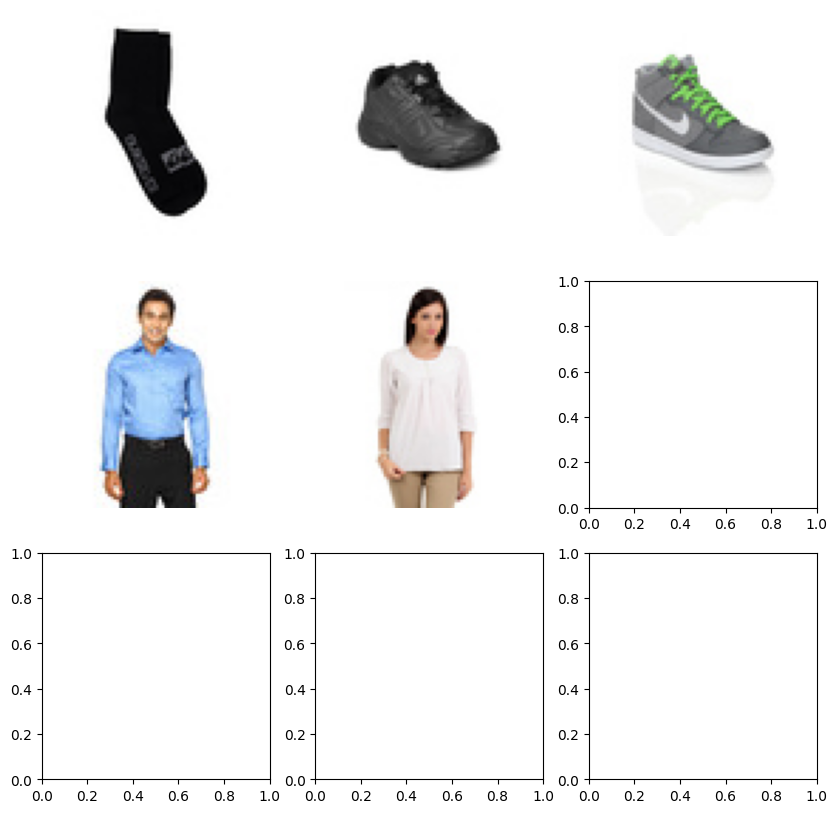

In [ ]:
find_matches(model, 
             image_embeddings,
             query="tshirt",
             image_filenames=valid_df['image'].values,
             n=5)

## Final words

I hope you have enjoyed this article. Implementing this paper was a really interesting experience for me. I want to thank Khalid Salama for the great Keras code example he provided which inspired me to write something similar in PyTorch.

!

In [ ]:
!pip install -qU datasets transformers sentence-transformers \
                 pinecone-client pinecone-text protobuf==3.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 566.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("3c1215ea-8adb-4c61-a39a-e605bf37be57") or "PINECONE_API_KEY"
# find your environment next to the api key in pinecone console
env = os.getenv("asia-southeast1-gcp-free") or "PINECONE_ENVIRONMENT"

# init connection to pinecone
pinecone.init(
    api_key=api_key,
    environment=env
)

In [ ]:
# # choose a name for your index
# index_name = "hybrid"

# if index_name not in pinecone.list_indexes():
#     # create the index
#     pinecone.create_index(
#       index_name,
#       dimension=512,
#       metric="dotproduct",
#       pod_type="Starter"
#     )
# pineconeIndex = pinecone.GRPCIndex(index_name)


## Connect with the pine cone
import pinecone
# init connection to pinecone
pinecone.init(
    api_key="3c1215ea-8adb-4c61-a39a-e605bf37be57", # app.pinecone.io
    environment="asia-southeast1-gcp-free" # find next to api key
)

index_name = "hybrid"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

# pineconeIndex = pinecone.GRPCIndex(index_name)


In [ ]:
index = pinecone.Index(index_name)

In [ ]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ashraq___parquet/ashraq--fashion-product-images-small-909c61a107795b31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [ ]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

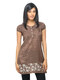

In [ ]:
# display a product image
images[900]

In [ ]:
# convert metadata into a pandas dataframe
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
"Turtle Check Men Navy Blue Shirt".lower().split()

['turtle', 'check', 'men', 'navy', 'blue', 'shirt']

In [ ]:
bm25.fit(metadata['productDisplayName'])

  0%|          | 0/44072 [00:00<?, ?it/s]

In [ ]:
metadata['productDisplayName'][0]

'Turtle Check Men Navy Blue Shirt'

In [ ]:
bm25.encode_queries(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596148,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.1493039556008558]}

In [ ]:
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

In [ ]:
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

AttributeError: ignored

In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/221 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
query = "dark blue french connection jeans for men"

# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

In [ ]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()  
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [ ]:
display_result(imgs)

In [ ]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

In [ ]:
question = "dark blue french connection jeans for men"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
query = "small beige handbag for women"
# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors - keyword search first
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
images[36254]

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Purple"}  # add to metadata filter
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
images[36256]

In [ ]:
query = "soft green color topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36256]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.6)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Green"}  # add to metadata filter
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
pinecone.delete_index(index_name)